<a href="https://colab.research.google.com/github/FatimZa/Hello-World/blob/main/Copie_de_MLP_BOHB_h.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install keras

In [ ]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras import backend as K

In [ ]:
import torchvision
import torchvision.transforms as transforms

In [2]:
pip install hpbandster

     |████████████████████████████████| 61kB 4.8MB/s 
     |████████████████████████████████| 92kB 5.8MB/s 
     |████████████████████████████████| 952kB 10.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for ConfigSpace: filename=ConfigSpace-0.4.18-cp37-cp37m-linux_x86_64.whl size=2879754 sha256=84b73a082ddf545893897d224fd5d72f144e49b0d26298660f509f77b19f6a9d
  Stored in directory: /root/.cache/pip/wheels/39/ea/40/d93931850f700427db0a84180829c709d30484c9475040c7bd
Successfully built ConfigSpace
  Created wheel for hpbandster: filename=hpbandster-0.7.4-cp37-none-any.whl size=80008 sha256=e2eb38acff4ea43ad22178713c3503327b706cc0d57cc063e1de1c8665fcc2c3
  Stored in directory: /root/.cache/pip/wheels/9d/57/62/6b00c8011bac96e0c404adc5be4e16964ba4544614240b4e23
  Created wheel for netifaces: filename=netifaces-0.10.9-cp37-cp37m-linux_x86_64.whl size=37434 sha256=5e8b59f82b3aa10383bbfd20922ad

In [ ]:
from hpbandster.core.worker import Worker

import logging
logging.basicConfig(level=logging.DEBUG)

import ConfigSpace as CS
import ConfigSpace.hyperparameters as CSH


In [ ]:
from tensorflow import keras
class KerasWorker(Worker):
    def __init__(self, N_train=8192, N_valid=1024, **kwargs):
            super().__init__(**kwargs)

            self.batch_size = 64

            img_rows = 28
            img_cols = 28
            self.num_classes = 10

            # the data, split between train and test sets
            (x_train, y_train), (x_test, y_test) = mnist.load_data()

            if K.image_data_format() == 'channels_first':
                    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
                    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
                    self.input_shape = (1, img_rows, img_cols)
            else:
                    #x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
                    #x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
                    
                    x_train = x_train.reshape(x_train.shape[0], img_rows* img_cols)
                    x_test = x_test.reshape(x_test.shape[0], img_rows*img_cols)
                    self.input_shape = (img_rows, img_cols, 1)


            x_train = x_train.astype('float32')
            x_test = x_test.astype('float32')
            # zero-one normalization
            x_train /= 255
            x_test /= 255


            # convert class vectors to binary class matrices
            y_train = keras.utils.to_categorical(y_train, self.num_classes)
            y_test = keras.utils.to_categorical(y_test, self.num_classes)


            self.x_train, self.y_train = x_train[:N_train], y_train[:N_train]
            self.x_validation, self.y_validation = x_train[-N_valid:], y_train[-N_valid:]
            self.x_test, self.y_test   = x_test, y_test

            self.input_shape = (img_rows, img_cols, 1)



    def get_configspace(self):
            """
            It builds the configuration space with the needed hyperparameters.
            It is easily possible to implement different types of hyperparameters.
            Beside float-hyperparameters on a log scale, it is also able to handle categorical input parameter.
            :return: ConfigurationsSpace-Object
            """
            cs = CS.ConfigurationSpace()
            lr = CSH.UniformFloatHyperparameter('lr', lower=1e-6, upper=1e-1, default_value='1e-2', log=True)

            # For demonstration purposes, we add different optimizers as categorical hyperparameters.
            # To show how to use conditional hyperparameters with ConfigSpace, we'll add the optimizers 'Adam' and 'SGD'.
            # SGD has a different parameter 'momentum'.
            optimizer = CSH.CategoricalHyperparameter('optimizer', ['Adam', 'SGD'])

            sgd_momentum = CSH.UniformFloatHyperparameter('sgd_momentum', lower=0.0, upper=0.99, default_value=0.9, log=False)

            cs.add_hyperparameters([lr, optimizer, sgd_momentum])
            
            dropout_rate = CSH.UniformFloatHyperparameter('dropout_rate', lower=0.0, upper=0.9, default_value=0.5, log=False)
            fonction_dactivation = CSH.CategoricalHyperparameter('activation_function', ['relu', 'tanh', 'softplus'])
            num_fc_units = CSH.UniformIntegerHyperparameter('num_fc_units', lower=8, upper=256, default_value=32, log=True)
            num_NN_perlayer = CSH.UniformIntegerHyperparameter('num_NN_perlayer', lower=1, upper=16, default_value=3, log=True)

            cs.add_hyperparameters([dropout_rate, num_fc_units, fonction_dactivation, num_NN_perlayer])


            # The hyperparameter sgd_momentum will be used,if the configuration
            # contains 'SGD' as optimizer.
            cond = CS.EqualsCondition(sgd_momentum, optimizer, 'SGD')
            cs.add_condition(cond)
            
            return cs
    def compute(self, config, budget, working_directory, *args, **kwargs):
            """
            Simple example for a compute function using a feed forward network.
            It is trained on the MNIST dataset.
            The input parameter "config" (dictionary) contains the sampled configurations passed by the bohb optimizer
            """

            model = Sequential()

            
            #model.add(Flatten())
            model.add(Dense(config['num_fc_units'], activation=config['activation_function']))
            
            model.add(Dropout(config['dropout_rate']))
            model.add(Dense(self.num_classes, activation='softmax'))


            if config['optimizer'] == 'Adam':
                    optimizer = keras.optimizers.Adam(lr=config['lr'])
            else:
                    optimizer = keras.optimizers.SGD(lr=config['lr'], momentum=config['sgd_momentum'])

            model.compile(loss="categorical_crossentropy",
                                      optimizer=optimizer,
                                      metrics=['accuracy'])
            model.fit(self.x_train, self.y_train,
                              batch_size=self.batch_size,
                              epochs=int(budget),
                              verbose=0,
                              validation_data=(self.x_validation,self.y_validation)
                              #validation_split=0.2
                      )
            train_score = model.evaluate(self.x_train, self.y_train, verbose=0)
            val_score = model.evaluate(self.x_validation, self.y_validation, verbose=0)
            test_score = model.evaluate(self.x_test, self.y_test, verbose=0)
            #model.summary()

            return ({
                    'loss': 1-val_score[1], # remember: HpBandSter always minimizes!
                    'info': {       'test accuracy': test_score[1],
                                            'train accuracy': train_score[1],
                                            'validation accuracy': val_score[1],
                                            'number of parameters': model.count_params(),
                                    }

            })




In [ ]:

for i in range(10):
    worker = KerasWorker(run_id='0')

    cs = worker.get_configspace()

    config = cs.sample_configuration().get_dictionary()
    print(config)

    res = worker.compute(config=config, budget=1, working_directory='.')
    print(res)
    print("****"*10)

11501568/11490434 [==============================] - 0s 0us/step
{'activation_function': 'softplus', 'dropout_rate': 0.5221848860714183, 'lr': 1.2107372462664597e-05, 'num_NN_perlayer': 1, 'num_fc_units': 72, 'optimizer': 'SGD', 'sgd_momentum': 0.008205746917554801}


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


{'loss': 0.892578125, 'info': {'test accuracy': 0.10289999842643738, 'train accuracy': 0.1070556640625, 'validation accuracy': 0.107421875, 'number of parameters': 57250}}
****************************************
{'activation_function': 'relu', 'dropout_rate': 0.6019491458108313, 'lr': 0.00031223788408558077, 'num_NN_perlayer': 14, 'num_fc_units': 122, 'optimizer': 'SGD', 'sgd_momentum': 0.19155001907553265}
{'loss': 0.8828125, 'info': {'test accuracy': 0.12439999729394913, 'train accuracy': 0.123291015625, 'validation accuracy': 0.1171875, 'number of parameters': 97000}}
****************************************
{'activation_function': 'softplus', 'dropout_rate': 0.6365917975966291, 'lr': 0.01418452253629039, 'num_NN_perlayer': 1, 'num_fc_units': 69, 'optimizer': 'Adam'}
{'loss': 0.080078125, 'info': {'test accuracy': 0.8845000267028809, 'train accuracy': 0.8995361328125, 'validation accuracy': 0.919921875, 'number of parameters': 54865}}
****************************************
{'acti

In [ ]:
import os
import pickle
import argparse


In [ ]:
import hpbandster.core.nameserver as hpns
import hpbandster.core.result as hpres

from hpbandster.optimizers import BOHB

import logging
logging.basicConfig(level=logging.DEBUG)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
min_budget=1

max_budget=19


In [ ]:
import os
import pickle
import argparse

import hpbandster.core.nameserver as hpns
import hpbandster.core.result as hpres

from hpbandster.optimizers import BOHB

import logging
logging.basicConfig(level=logging.DEBUG)

In [ ]:
nic_name="lo"
host = hpns.nic_name_to_host(nic_name)

shared_directory="."
result_logger = hpres.json_result_logger(directory=shared_directory, overwrite=False)


# Start a nameserver:
run_id="12"#lzm ykon unique
NS = hpns.NameServer(run_id=run_id, host=host, port=0, working_directory=shared_directory)
ns_host, ns_port = NS.start()

# Start local worker
w = KerasWorker (run_id=run_id, host=host, nameserver=ns_host, nameserver_port=ns_port, timeout=120)
w.run(background=True)

# Run an optimizer
min_budget=1
max_budget=19
bohb = BOHB(  configspace = worker.get_configspace(),
                      run_id = run_id,
                      host=host,
                      nameserver=ns_host,
                      nameserver_port=ns_port,
                      result_logger=result_logger,
                      min_budget=min_budget, max_budget=max_budget,
               )
n_iterations=16
res = bohb.run(n_iterations=n_iterations)

# store results
with open(os.path.join(shared_directory, 'results.pkl'), 'wb') as fh:
    pickle.dump(res, fh)

# shutdown
bohb.shutdown(shutdown_workers=True)
NS.shutdown()

DEBUG:hpbandster:wait_for_workers trying to get the condition
DEBUG:hpbandster.run_12.worker.03f83a93093a.58:WORKER: Connected to nameserver <Pyro4.core.Proxy at 0x7f0a554b5590; connected IPv4; for PYRO:Pyro.NameServer@127.0.0.1:45623>
DEBUG:hpbandster.run_12.worker.03f83a93093a.58:WORKER: No dispatcher found. Waiting for one to initiate contact.
INFO:hpbandster.run_12.worker.03f83a93093a.58:WORKER: start listening for jobs
INFO:hpbandster:DISPATCHER: started the 'discover_worker' thread
INFO:hpbandster:DISPATCHER: started the 'job_runner' thread
INFO:hpbandster:DISPATCHER: Pyro daemon running on 127.0.0.1:41935
DEBUG:hpbandster:DISPATCHER: Starting worker discovery
DEBUG:hpbandster:DISPATCHER: Found 1 potential workers, 0 currently in the pool.
INFO:hpbandster:DISPATCHER: discovered new worker, hpbandster.run_12.worker.03f83a93093a.58139687728105344
DEBUG:hpbandster:HBMASTER: number of workers changed to 1
DEBUG:hpbandster:Enough workers to start this run!
DEBUG:hpbandster:DISPATCHER:

In [ ]:
import matplotlib.pyplot as plt
import hpbandster.core.result as hpres
import hpbandster.visualization as hpvis

In [ ]:
result = hpres.logged_results_to_HBS_result(".")


In [ ]:
# get all executed runs
all_runs = result.get_all_runs()


Best found configuration:
{'activation_function': 'relu', 'dropout_rate': 0.6315487163822624, 'lr': 0.0016764097224581907, 'num_NN_perlayer': 8, 'num_fc_units': 220, 'optimizer': 'Adam'}
It achieved accuracies of 0.974609 (validation) and 0.954600 (test).


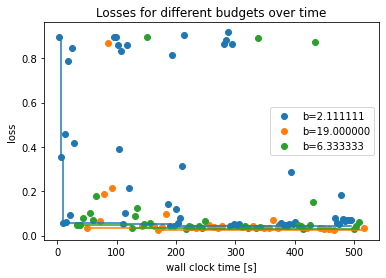

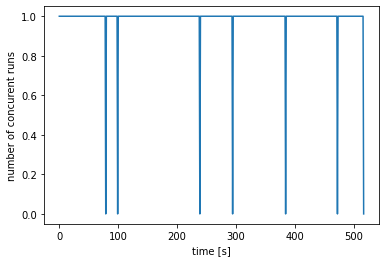

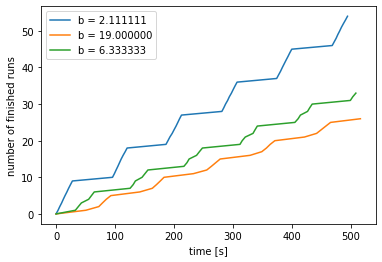

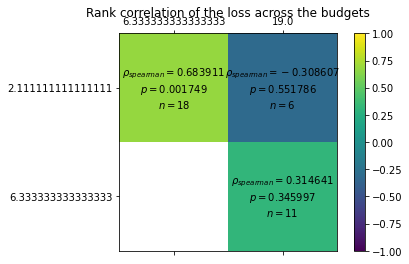

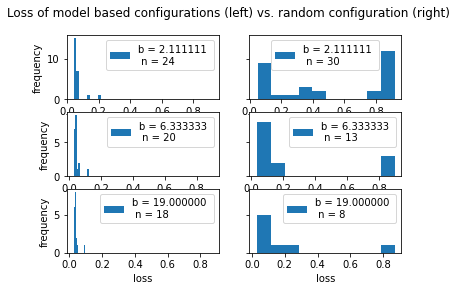

In [3]:
import matplotlib.pyplot as plt
import hpbandster.core.result as hpres
import hpbandster.visualization as hpvis



# load the example run from the log files
result = hpres.logged_results_to_HBS_result('')

# get all executed runs
all_runs = result.get_all_runs()

# get the 'dict' that translates config ids to the actual configurations
id2conf = result.get_id2config_mapping()


# Here is how you get he incumbent (best configuration)
inc_id = result.get_incumbent_id()

# let's grab the run on the highest budget
inc_runs = result.get_runs_by_id(inc_id)
inc_run = inc_runs[-1]


# We have access to all information: the config, the loss observed during
#optimization, and all the additional information
inc_loss = inc_run.loss
inc_config = id2conf[inc_id]['config']
inc_test_loss = inc_run.info['test accuracy']

print('Best found configuration:')
print(inc_config)
print('It achieved accuracies of %f (validation) and %f (test).'%(1-inc_loss, inc_test_loss))


# Let's plot the observed losses grouped by budget,
hpvis.losses_over_time(all_runs)

# the number of concurent runs,
hpvis.concurrent_runs_over_time(all_runs)

# and the number of finished runs.
hpvis.finished_runs_over_time(all_runs)

# This one visualizes the spearman rank correlation coefficients of the losses
# between different budgets.
hpvis.correlation_across_budgets(result)

# For model based optimizers, one might wonder how much the model actually helped.
# The next plot compares the performance of configs picked by the model vs. random ones
hpvis.performance_histogram_model_vs_random(all_runs, id2conf)

plt.show()